---
### Today_Code : 비즈니스 데이터 분석 - 다이소와 유사한 잡화 거래 데이터는 어떤 구성일까?
- source : https://www.youtube.com/watch?v=VEtav1uGZLo&list=PLaTc2c6yEwmrmhNM4jVc22ochFjQMK5Ab
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

import datetime as dt 

In [2]:
## 한글사용을 위한 패키지 
#!pip install koreanize-matplotlib
import koreanize_matplotlib

---
### 1. data loading 
- UK online retail dataset (https://archive.ics.uci.edu/dataset/352/online+retail)
- 파일 처리속도를 빠르게 하기 위해, 엑셀 파일을 csv로 변환하였음 
- 마찬가지로 object 타입의 변수들을 category 타입으로 변환
---

In [3]:
df = pd.read_csv('data/Online Retail.csv')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['StockCode'] = df['StockCode'].astype('category')
df['Description'] = df['Description'].astype('category')
df['InvoiceDate'] = df['InvoiceDate'].astype('category')
df['Country'] = df['Country'].astype('category')

---
### ※ columns description
- InvoiceNo: 송장번호. 해당 거래에 할당된 6자리 정수, 문자 'c'로 시작하면 취소를 나타냅니다.
- StockCode: 제품 코드. 각 고유 제품에 고유하게 할당된 5자리 정수
- Description: 제품 이름
- Quantity: 거래당 각 제품의 수량,  ‘-’(마이너스)로 시작하면 취소를 나타냅니다.
- InvoiceDate: 송장 날짜 및 시간. 숫자, 각 거래가 생성된 날짜 및 시간
- UnitPrice: 단가. 숫자, 스털링(영국 화폐) 단위의 제품 가격
- CustomerID: 고객 번호. 해당 고객에게 고유하게 할당된 5자리 정수
- Country: 국가 이름. 해당 고객이 거주하는 국가의 이름 
---

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    541909 non-null  category
 1   StockCode    541909 non-null  category
 2   Description  540455 non-null  category
 3   Quantity     541909 non-null  int64   
 4   InvoiceDate  541909 non-null  category
 5   UnitPrice    541909 non-null  float64 
 6   CustomerID   406829 non-null  float64 
 7   Country      541909 non-null  category
dtypes: category(5), float64(2), int64(1)
memory usage: 19.3 MB


- InvoiceDate가 카테고리 타입, Datatime 형태로 변경 필요 
- Description, CustomerID 컬럼에 null값 존재 

---
### 2. 기초 통계량과 결측치 확인 
- describe(), isnull(), sns.heatmap, hist
---

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- 판매량과 가격에 마이너스 값 존재(반품?) --> 분석시 삭제 검토 
- 매우 극단적인 매출건이 존재하는 듯 

In [8]:
## 수치데이터가 아닌 변수들 확인 
#df.describe(include= 'all')
df.describe(exclude= 'number')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


- "주문번호 573585 : ~~ T-LIGHT HOLDER"가 2011년 10/31에 무려 1114건이나 주문되었다. 
- 참고. freq는 top이 발생한 빈도수를 나타냄 

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64
------------------------------------------


<AxesSubplot:>

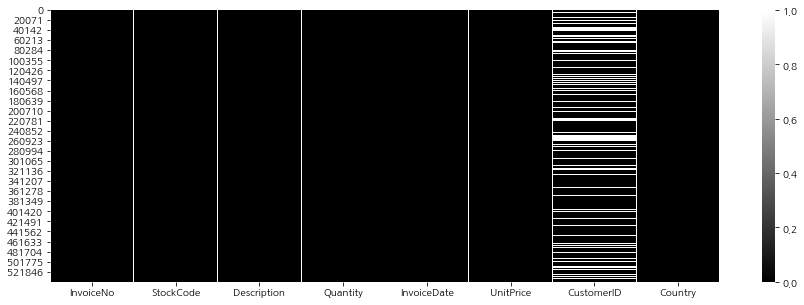

In [10]:
## 결측치 비중 확인 및 시각화
print(df.isnull().mean() * 100)
print('------------------------------------------')
plt.figure(figsize = (15,5))
sns.heatmap(df.isnull(), cmap = 'gray')

- Description이 없는 건은 매우 미미한 수준이나, CustomerID의 약 1/4이 결측치 (비회원 주문건?) 

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


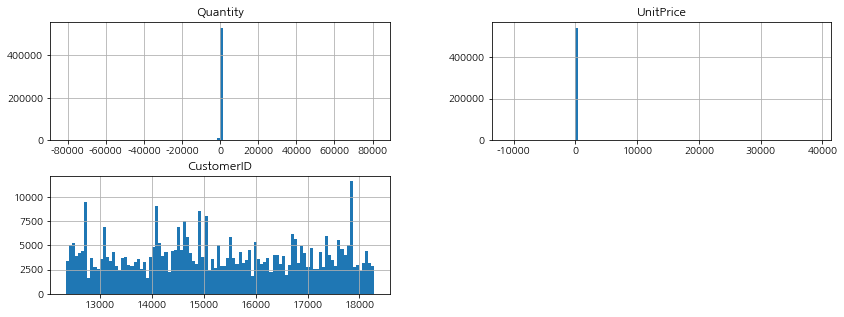

In [11]:
## 수치형 변수들의 분포 확인 
print(df.describe())
df.hist(figsize = (14, 5), bins = 100) ;

---
### 3. Basic Feature engineering -1
- RFM 분석을 위한 Total_price(= UnitPrice x Quantity) 만들기
- 회원과 비회원 구매건의 구분 
- 구매 취소건 확인 
---

In [12]:
## Total_price(= UnitPrice x Quantity)
df['Total_price'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34


In [13]:
## 가설: CustomerID가 결측치이면 비회원, 비회원 비율 구하기 
df['CustomerID'].isnull().value_counts(normalize = True)

False    0.750733
True     0.249267
Name: CustomerID, dtype: float64

In [14]:
## 국가별 회원 수(결측치가 아닌) 구하기 
df.loc[df['CustomerID'].notnull(), 'Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [15]:
## 반대로 국가별 결측치 수를 구하기 (~은 반대를 나타냄)
df.loc[~df['CustomerID'].notnull(), 'Country'].value_counts()

United Kingdom          133600
EIRE                       711
Hong Kong                  288
Unspecified                202
Switzerland                125
France                      66
Israel                      47
Portugal                    39
Bahrain                      2
United Arab Emirates         0
Netherlands                  0
Norway                       0
Poland                       0
RSA                          0
USA                          0
Saudi Arabia                 0
Lithuania                    0
Singapore                    0
Spain                        0
Sweden                       0
Malta                        0
Australia                    0
Lebanon                      0
Japan                        0
Austria                      0
Iceland                      0
Greece                       0
Germany                      0
Finland                      0
European Community           0
Denmark                      0
Czech Republic               0
Cyprus  

In [16]:
## 역시 영국 쇼핑몰이다 보니 회원도 비회원도 영국인이 가장 많다. 
## 회원등록여부 구분 컬럼 생성 하기 
df['isRegistered'] = df['CustomerID'].notnull()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,15.30,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,22.00,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34,True


In [17]:
print(df['isRegistered'].value_counts())
print('---------------------------------------')
## crosstal으로 국가별 회원등록 여부 비교 
pd.crosstab(df['Country'], df['isRegistered']).sort_values(True, ascending=False)

True     406829
False    135080
Name: isRegistered, dtype: int64
---------------------------------------


isRegistered,False,True
Country,,
United Kingdom,133600,361878
Germany,0,9495
France,66,8491
EIRE,711,7485
Spain,0,2533
Netherlands,0,2371
Belgium,0,2069
Switzerland,125,1877
Portugal,39,1480


In [18]:
## 구매취소건 구분하기 (InvoiceNo가 c로 시작하는 경우)
## 정규표현식으로 숫자를 모두 지워서 취소건수를 파악한다. 
df['InvoiceCode'] = df['InvoiceNo'].str.replace('[0-9]', '', regex=True)
df['InvoiceCode'].value_counts()

     532618
C      9288
A         3
Name: InvoiceCode, dtype: int64

In [19]:
df['isCancel'] = (df['InvoiceCode'] == 'C')
df['isCancel'].value_counts()

False    532621
True       9288
Name: isCancel, dtype: int64

In [20]:
## 가설 : 회원과 비회원간에 매출취소 비중의 차이가 존재한다? 
## 회원등록 건수 대비, 매출 취소건 비교 
pd.crosstab(df['isRegistered'], df['isCancel'])

isCancel,False,True
isRegistered,,
False,134697,383
True,397924,8905


In [21]:
## InvoiceCode = A의 정체는? 
df[df['InvoiceCode'] == 'A']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50,11062.06,NaN,United Kingdom,11062.06,False,A,False
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51,-11062.06,NaN,United Kingdom,-11062.06,False,A,False
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52,-11062.06,NaN,United Kingdom,-11062.06,False,A,False


In [22]:
## groupby()를 사용하여 고객별 구매취소건 데이터를 생성 
## unstack() : 피봇테이블 형태로 보여준다. 
df.groupby(['CustomerID', 'isCancel'])['InvoiceNo'].count().unstack()

isCancel,False,True
CustomerID,,
12346.0,1.0,1.0
12347.0,182.0,NaN
12348.0,31.0,NaN
12349.0,73.0,NaN
12350.0,17.0,NaN
...,...,...
18280.0,10.0,NaN
18281.0,7.0,NaN
18282.0,12.0,1.0


In [23]:
## crosstab과 groupby는 동일한 매커니즘 
pd.crosstab(df['CustomerID'], df['isCancel'])

isCancel,False,True
CustomerID,,
12346.0,1,1
12347.0,182,0
12348.0,31,0
12349.0,73,0
12350.0,17,0
...,...,...
18280.0,10,0
18281.0,7,0
18282.0,12,1


In [24]:
## 취소비율 구하기 
customer_cancel = pd.crosstab(df['CustomerID'], df['isCancel'])
customer_cancel.columns = ['정상', '취소']
customer_cancel['취소비율%'] = (customer_cancel['취소'] / customer_cancel['정상']) *100
customer_cancel

,정상,취소,취소비율%
CustomerID,,,
12346.0,1,1,100.000000
12347.0,182,0,0.000000
12348.0,31,0,0.000000
12349.0,73,0,0.000000
12350.0,17,0,0.000000
...,...,...,...
18280.0,10,0,0.000000
18281.0,7,0,0.000000
18282.0,12,1,8.333333


In [25]:
## 취소를 가장 많이한 top10은? 
customer_cancel.nlargest(10, '취소')

,정상,취소,취소비율%
CustomerID,,,
14911.0,5677,226,3.980976
17841.0,7847,136,1.733146
17511.0,963,113,11.734164
15311.0,2379,112,4.707860
12607.0,101,101,100.000000
14410.0,194,93,47.938144
13798.0,349,90,25.787966
14606.0,2700,82,3.037037
13113.0,201,79,39.303483


---
### 4. Basic Feature engineering -2
- ※ 상품 code x description 마스터 만들기 
- 비회원 구매와 구매 취소건 제외 
- 날짜/시간 분석을 변수 생성 (from InvoiceDate)
---

In [26]:
'''
※ 중요 : 상품 code x description master 만들기 
1) StockCode와 Description 테이블을 만들고, StockCode 기준으로 중복제거 
2) 결측치 제거하고, StockCode를 인덱스로 세팅 
'''
df_stock_desc = df[['StockCode', 'Description']].drop_duplicates('StockCode').dropna().set_index('StockCode')
df_stock_desc

,Description
StockCode,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...
85179a,GREEN BITTY LIGHT CHAIN
23617,SET 10 CARDS SWIRLY XMAS TREE 17104
90214U,"LETTER ""U"" BLING KEY RING"


In [27]:
## 상품 code 마스터를 사용하여, 제품별 구매취소 비율 파악 
stock_cancel = pd.crosstab(df['StockCode'], df['isCancel'])
stock_cancel.join(df_stock_desc)

,False,True,Description
StockCode,,,
10002,73,0,INFLATABLE POLITICAL GLOBE
10080,24,0,GROOVY CACTUS INFLATABLE
10120,30,0,DOGGY RUBBER
10123C,4,0,HEARTS WRAPPING TAPE
10123G,1,0,NaN
...,...,...,...
gift_0001_20,10,0,Dotcomgiftshop Gift Voucher ?20.00
gift_0001_30,8,0,Dotcomgiftshop Gift Voucher ?30.00
gift_0001_40,3,0,Dotcomgiftshop Gift Voucher ?40.00


In [28]:
## join과 동일한 방법 : merge
stock_cancel.merge(df_stock_desc, left_index = True, right_index = True)

,False,True,Description
StockCode,,,
10002,73,0,INFLATABLE POLITICAL GLOBE
10080,24,0,GROOVY CACTUS INFLATABLE
10120,30,0,DOGGY RUBBER
10123C,4,0,HEARTS WRAPPING TAPE
10124A,5,0,SPOTS ON RED BOOKCOVER TAPE
...,...,...,...
gift_0001_20,10,0,Dotcomgiftshop Gift Voucher ?20.00
gift_0001_30,8,0,Dotcomgiftshop Gift Voucher ?30.00
gift_0001_40,3,0,Dotcomgiftshop Gift Voucher ?40.00


In [29]:
## join과 동일한 방법 :  add column 
stock_cancel['Desc'] = df_stock_desc['Description']
stock_cancel

isCancel,False,True,Desc
StockCode,,,
10002,73,0,INFLATABLE POLITICAL GLOBE
10080,24,0,GROOVY CACTUS INFLATABLE
10120,30,0,DOGGY RUBBER
10123C,4,0,HEARTS WRAPPING TAPE
10123G,1,0,NaN
...,...,...,...
gift_0001_20,10,0,Dotcomgiftshop Gift Voucher ?20.00
gift_0001_30,8,0,Dotcomgiftshop Gift Voucher ?30.00
gift_0001_40,3,0,Dotcomgiftshop Gift Voucher ?40.00


In [30]:
## 가장 많이 팔린 상품 top10의 취소건수는 얼마나? 
stock_cancel.columns = ['정상', '취소', '설명']
stock_cancel['취소비율%'] = (stock_cancel['취소'] / stock_cancel['정상']) *100

stock_cancel.nlargest(10, '정상')

,정상,취소,설명,취소비율%
StockCode,,,,
85123A,2271,42,WHITE HANGING HEART T-LIGHT HOLDER,1.849406
85099B,2115,44,JUMBO BAG RED RETROSPOT,2.080378
22423,2022,181,REGENCY CAKESTAND 3 TIER,8.951533
47566,1707,20,PARTY BUNTING,1.171646
20725,1595,44,LUNCH BAG RED RETROSPOT,2.758621
84879,1490,12,ASSORTED COLOUR BIRD ORNAMENT,0.805369
22197,1426,50,SMALL POPCORN HOLDER,3.506311
22720,1403,74,SET OF 3 CAKE TINS PANTRY DESIGN,5.274412
21212,1370,15,PACK OF 72 RETROSPOT CAKE CASES,1.094891


In [31]:
## 가장 취소가 많았던 상품 top10 
stock_cancel.nlargest(10, '취소')

,정상,취소,설명,취소비율%
StockCode,,,,
M,327,244,Manual,74.617737
22423,2022,181,REGENCY CAKESTAND 3 TIER,8.951533
POST,1130,126,POSTAGE,11.150442
22960,1142,87,JAM MAKING SET WITH JARS,7.618214
D,0,77,Discount,inf
22720,1403,74,SET OF 3 CAKE TINS PANTRY DESIGN,5.274412
21232,843,61,STRAWBERRY CERAMIC TRINKET BOX,7.236062
S,2,61,SAMPLES,3050.000000
22699,1084,54,ROSES REGENCY TEACUP AND SAUCER,4.981550


In [32]:
## 고객id가 없는 건과 판매량/가격이 마이너스인건은 삭제 
df_valid = df[(df['CustomerID'].notnull()) & (df['Quantity'] > 0) & (df['UnitPrice']>0)]
print('- result: ', df.shape, ' --> ', df_valid.shape)
df_valid.head()

- result:  (541909, 12)  -->  (397884, 12)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,15.30,True,,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34,True,,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,22.00,True,,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34,True,,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,20.34,True,,False


In [33]:
## 중복 제거 
df_valid = df_valid.drop_duplicates().copy()
df_valid.shape

(392692, 12)

In [34]:
## InvoiceDate의 type 변경
print(df_valid['InvoiceDate'].dtypes) 
print('-------------------------------------------')

df_valid['InvoiceDate'] = pd.to_datetime(df_valid['InvoiceDate'])
print(df_valid['InvoiceDate'].dtypes) 

category
-------------------------------------------
datetime64[ns]


In [35]:
## 연,월,일,요일,time, hour 추출 
df_valid['InvoiceYear'] = df_valid['InvoiceDate'].dt.year
df_valid['InvoiceMonth'] = df_valid['InvoiceDate'].dt.month
df_valid['InvoiceDay'] = df_valid['InvoiceDate'].dt.day
df_valid['InvoiceDow'] = df_valid['InvoiceDate'].dt.dayofweek
df_valid['InvoiceTime'] = df_valid['InvoiceDate'].dt.time
df_valid['InvoiceHour'] = df_valid['InvoiceDate'].dt.hour

df_valid.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,True,,False,2010,12,1,2,08:26:00,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,True,,False,2010,12,1,2,08:26:00,8


In [36]:
## 다년간의 데이터이므로, 연-월 추출 : InvoiceDate의 앞부분 7글자만 가져온다 
df_valid['InvoiceYM'] = df_valid['InvoiceDate'].astype(str).str[:7]
df_valid.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour,InvoiceYM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,True,,False,2010,12,1,2,08:26:00,8,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,True,,False,2010,12,1,2,08:26:00,8,2010-12


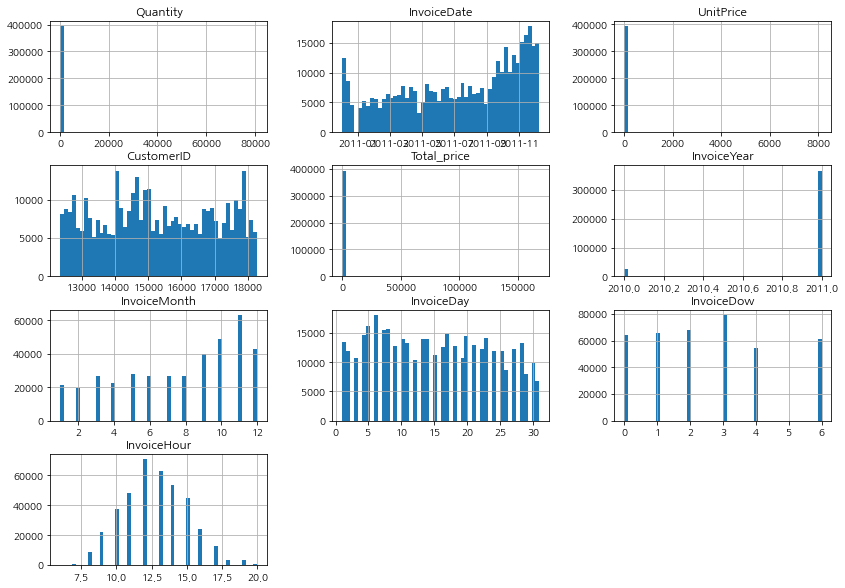

In [37]:
## 전처리 결과 확인 
df_valid.hist(figsize = (14,10), bins = 50) ;

[Text(0.5, 1.0, 'cnt by month')]

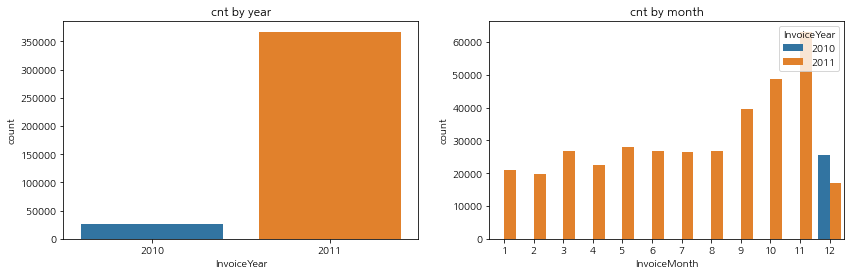

In [38]:
## 2010년 데이터가 별로 없는것 같다. --> 확인 
figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(14,4)
sns.countplot(data=df_valid, x='InvoiceYear', ax=ax1)
sns.countplot(data=df_valid, x='InvoiceMonth', hue = 'InvoiceYear', ax=ax2)
ax1.set(title = 'cnt by year')
ax2.set(title = 'cnt by month')

<AxesSubplot:xlabel='InvoiceYM', ylabel='count'>

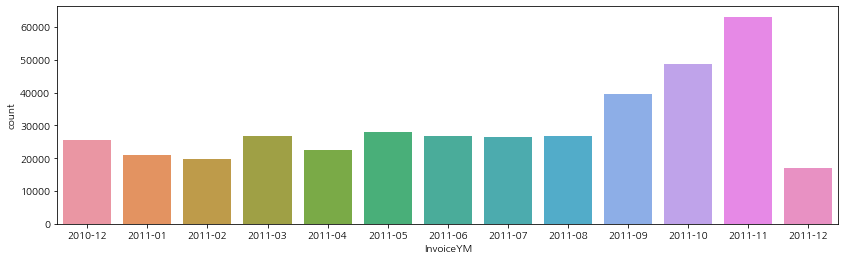

In [39]:
plt.figure(figsize=(14,4))
sns.countplot(data=df_valid, x='InvoiceYM')

In [40]:
## 토요일의 데이터가 없는것 같다 --> 확인 
## 먼저 map과 lambda 함수를 사용, 요일 코드 (0~6)을 알기쉽게 문자로 바꿔주자.
df_valid['InvoceDayName'] = df_valid['InvoiceDow'].map(lambda x : '월화수목금토일'[x])
df_valid.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour,InvoiceYM,InvoceDayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,True,,False,2010,12,1,2,08:26:00,8,2010-12,수
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,True,,False,2010,12,1,2,08:26:00,8,2010-12,수


목    79243
수    68040
화    65744
월    64231
일    61212
금    54222
Name: InvoceDayName, dtype: int64


<AxesSubplot:xlabel='InvoceDayName', ylabel='count'>

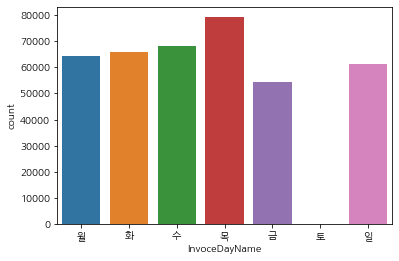

In [41]:
print( df_valid['InvoceDayName'].value_counts() )

sns.countplot(data=df_valid, x='InvoceDayName', order=list('월화수목금토일'))

[Text(0.5, 1.0, '시간대별 매출금액')]

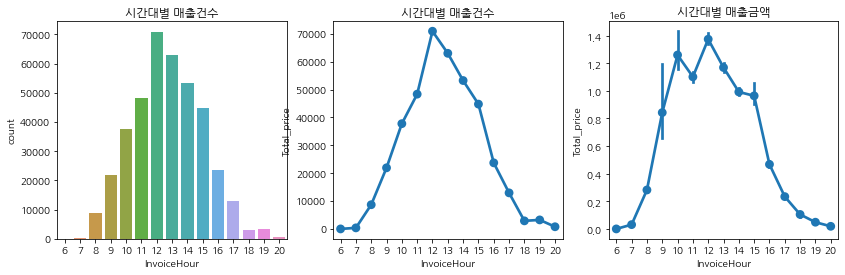

In [50]:
## 시간대별 구매 현황 파악 (countplot, pointplot)
## pointplot의 estimator = len/sum으로 설정하여, 각각 구매건수/매출합계금액을 기준으로 표시 
figure, (ax1,ax2, ax3) = plt.subplots(ncols=3)
figure.set_size_inches(14,4)
sns.countplot(data=df_valid, x='InvoiceHour', ax=ax1)
sns.pointplot(data=df_valid, x='InvoiceHour', y = 'Total_price', estimator = len, errorbar=None, ax=ax2)
sns.pointplot(data=df_valid, x='InvoiceHour', y = 'Total_price', estimator = sum, errorbar=None, ax=ax3)
ax1.set(title = '시간대별 매출건수')
ax2.set(title = '시간대별 매출건수')
ax3.set(title = '시간대별 매출금액')

In [59]:
## 시간대 x 요일별 분석 
hour_dow = pd.crosstab(df_valid['InvoiceHour'], df_valid['InvoceDayName'])
hour_dow[list('월화수목금일')]

InvoceDayName,월,화,수,목,금,일
InvoiceHour,,,,,,
6,0,0,0,1,0,0
7,61,65,59,64,130,0
8,1563,1710,1818,1763,1833,0
9,4345,4542,4078,4569,4368,25
10,6106,6575,6927,7528,7161,3476
11,7401,8418,8292,7134,7189,9931
12,10585,11903,12684,12908,9765,13093
13,10459,10274,11137,11446,8300,11403
14,9119,9428,8716,9173,7227,9588


In [79]:
# axis=None : 전체 셀 기준으로 농도표시, format 옵션으로 값 표시방식 조정  
hour_dow[list('월화수목금일')].style.background_gradient(axis=None, cmap='Blues').format('{:,}')  

#hour_dow[list('월화수목금일')].style.background_gradient(axis=0)    # axis=0 : 열 기준으로 농도 표시 
#hour_dow[list('월화수목금일')].style.background_gradient(axis=1)    # axis=1 : 행 기준으로 농도 표시

InvoceDayName,월,화,수,목,금,일
InvoiceHour,,,,,,
6,0,0,0,1,0,0
7,61,65,59,64,130,0
8,"1,563","1,710","1,818","1,763","1,833",0
9,"4,345","4,542","4,078","4,569","4,368",25
10,"6,106","6,575","6,927","7,528","7,161","3,476"
11,"7,401","8,418","8,292","7,134","7,189","9,931"
12,"10,585","11,903","12,684","12,908","9,765","13,093"
13,"10,459","10,274","11,137","11,446","8,300","11,403"
14,"9,119","9,428","8,716","9,173","7,227","9,588"


<AxesSubplot:xlabel='InvoceDayName', ylabel='InvoiceHour'>

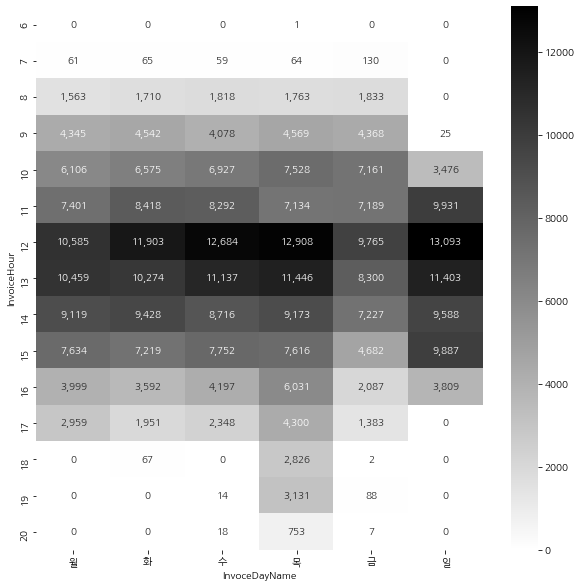

In [78]:
## heatmap을 이용한 시각화 방법, annot=True 옵션으로 값 표시, fmt 옵션으로 값 표시방식 조정  
plt.figure(figsize=(10,10))
sns.heatmap(hour_dow[list('월화수목금일')], cmap='gray_r', annot=True, fmt=',.0f')

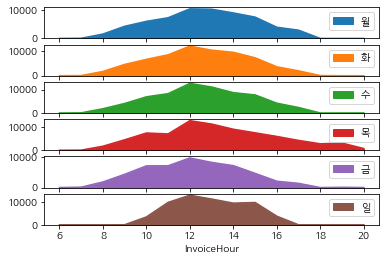

In [88]:
#plot을 사용한 간단한 시각화 --> 일요일은 상대적으로 정오무렵에 주문이 몰리고 있음을 알수 있다. 
hour_dow[list('월화수목금일')].plot(subplots=True, kind='area') ;

In [89]:
## export the df_valid for next study 
import pyarrow as pa
import pyarrow.parquet as pq 

df_valid.to_parquet('data/df_valid.parquet', engine='pyarrow', index=False)